# Baseline Model

Preprocces so we can build model, in that caase:
Removing timestamp feature since it problematic to encode and cannot be used without handling.
I Used Label encoder (SKLearn) to encode data so it can be used in our model to predict.


In [331]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn import  preprocessing
from sklearn.metrics import mean_squared_error
# Load the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Define the features and target for training
X_train = train_df.drop(columns=["price_doc","timestamp", "id"])
train_df["price_doc"] = np.log1p(train_df.price_doc.values.astype('int'))
y_train = train_df["price_doc"]

test_x = test_df.drop(columns=["timestamp", "id"])

for c in X_train.columns:
    if X_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[c].values)) 
        X_train[c] = lbl.transform(list(X_train[c].values))

for c in test_x.columns:
    if test_x[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test_x[c].values)) 
        test_x[c] = lbl.transform(list(test_x[c].values))


# Define the XGBoost model parameters
params = {
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
    "silent": 1
}


#Convert the data into the format required by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(test_x)

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100,  verbose_eval=20)

# Make predictions on the test set
y_test = model.predict(dtest)
y_test_unlog = np.expm1(y_test)
# Save the predictions to a CSV file
pd.DataFrame({"id": test_df["id"], "price_doc": y_test_unlog}).to_csv("submission_base_model.csv", index=False)

# Using KFold cross-validation to train and evaluate the model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]
    dtrain = xgb.DMatrix(X_train_kf, label=y_train_kf)
    dval = xgb.DMatrix(X_val_kf, label=y_val_kf)
    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, "val")], early_stopping_rounds=100, verbose_eval=20)
    y_val_pred = model.predict(dval)
    cv_scores.append(mean_squared_error(y_val_kf, y_val_pred) ** 0.5)


#Evaluate the mean and standard deviation of the cv scores
print(f'Mean cv RMSE: {np.mean(cv_scores)} +/- {np.std(cv_scores)}')




[0]	val-rmse:14.3556
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.16547
[40]	val-rmse:1.90419
[60]	val-rmse:0.810859
[80]	val-rmse:0.523019
[99]	val-rmse:0.473256
[0]	val-rmse:14.3744
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.17947
[40]	val-rmse:1.91418
[60]	val-rmse:0.819316
[80]	val-rmse:0.529765
[99]	val-rmse:0.478175
[0]	val-rmse:14.3728
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.17896
[40]	val-rmse:1.91489
[60]	val-rmse:0.818213
[80]	val-rmse:0.525238
[99]	val-rmse:0.471541
[0]	val-rmse:14.3658
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.17219
[40]	val-rmse:1.91043
[60]	val-rmse:0.820742
[80]	val-rmse:0.53526
[99]	val-rmse:0.484746
[0]	val-rmse:14.3646
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.17036
[40]	val-rmse:1.90591
[60]	val-rmse:0.814739
[80]	val-rmse:0.529393
[99]	val-rmse:0.479909
Mean cv RMSE: 0.47752530667268694 +/- 0.004738

**RMSE: 0.47752530667268694 +/- 0.00473872952873222**

**Kaggle Score: *Public:* 0.35645 *Private:* 0.354**

# Improved Model

Once I have a baseline model, the next step is to improve the model by trying different techniques and approaches

Some data analysis to focus the model improvment:

In [332]:
train_df = pd.read_csv("train.csv")

# Get summary statistics of numerical variables
train_df.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


In [333]:

# Check for missing values
train_df.isnull().sum()


id                       0
timestamp                0
full_sq                  0
life_sq               6383
floor                  167
                      ... 
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
price_doc                0
Length: 292, dtype: int64

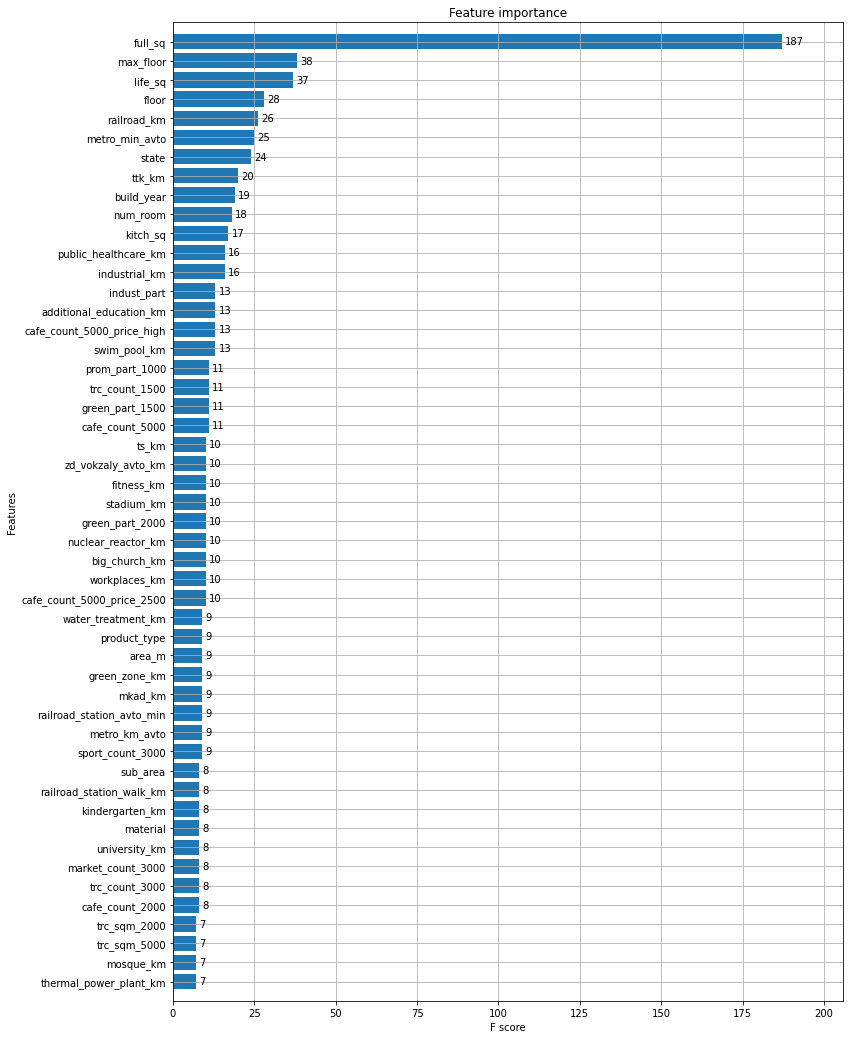

In [334]:
# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()


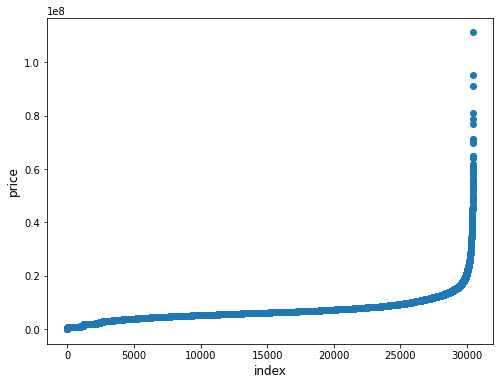

In [335]:
# price_doc plot to look for outliers 

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

<AxesSubplot:xlabel='price_doc', ylabel='Count'>

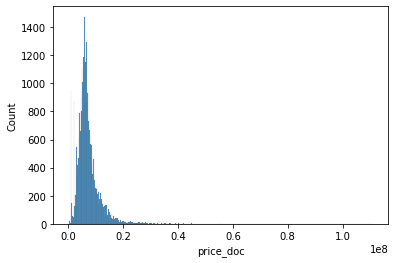

In [336]:

# Visualize the distribution of the target variable
import seaborn as sns
sns.histplot(train_df['price_doc'], kde=False)


<AxesSubplot:xlabel='price_doc', ylabel='Count'>

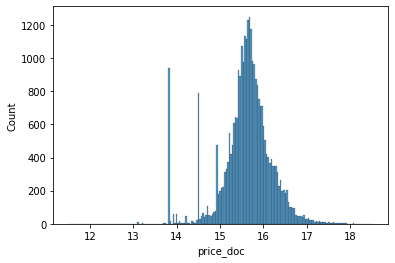

In [337]:
#Price log
sns.histplot(np.log(train_df['price_doc']), kde=False)

<Figure size 864x864 with 0 Axes>

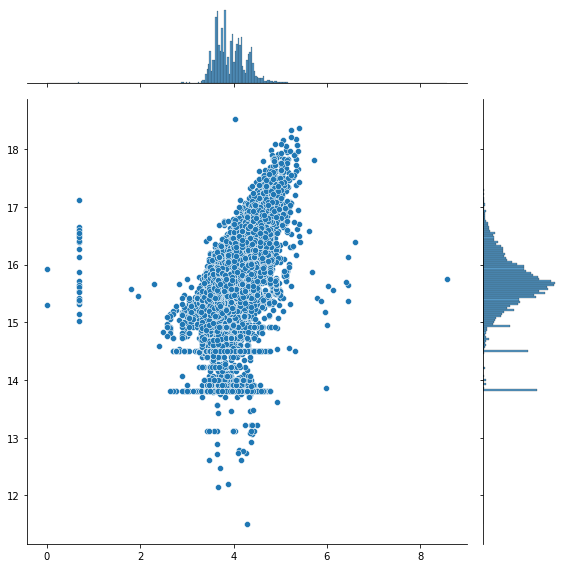

In [338]:
# Log of Total area in square metre

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), height=8)
plt.ylabel('Log of Price', fontsize=18)
plt.xlabel('Log of Total area in square metre', fontsize=18)
plt.show()

<AxesSubplot:>

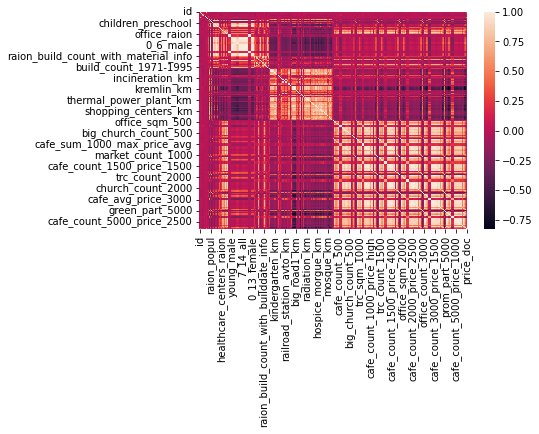

In [339]:

# Visualize the correlation between numerical variables
sns.heatmap(train_df.corr())

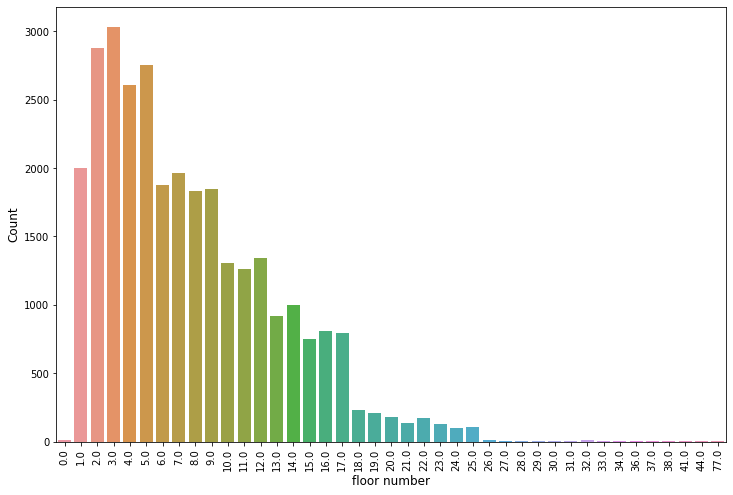

In [340]:
# Floor number in numbers of houses
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [341]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import  preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb

# Load the dataset
train_df_org = pd.read_csv("train.csv")
test_df_org = pd.read_csv("test.csv")

train_df = train_df_org.copy()
test_df = test_df_org.copy()


# Correcting feature full_sq
train_df.loc[train_df.full_sq == 0, 'full_sq'] = 50
test_df.loc[test_df['full_sq'] == 0, 'full_sq'] = 50


# Remove price outliers as seen earlier
train_df=train_df[(train_df.price_doc>1e6)]

train_df = train_df[train_df['price_doc']/train_df['full_sq'] <= 600000]
train_df = train_df[train_df['price_doc']/train_df['full_sq'] >= 10000]


# Correcting feature build_year
train_df.loc[train_df['build_year'] > 2018, 'build_year'] = np.nan
train_df.loc[train_df['build_year'] < 1000, 'build_year'] = np.nan

test_df.loc[test_df['build_year'] > 2018, 'build_year'] = np.nan
test_df.loc[test_df['build_year'] < 1000, 'build_year'] = np.nan

# Replacing the values in ordinal manner (poor=1,satisfactory=2,good=3,excellent=4)

mapping = {'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4 ,'no data':5}
train_df.ecology = [mapping[item] for item in train_df.ecology]
train_df.loc[train_df['ecology'] == 5, 'ecology'] = np.nan

mapping = {'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4 ,'no data':5}
test_df.ecology = [mapping[item] for item in test_df.ecology]
test_df.loc[test_df['ecology'] == 5, 'ecology'] = np.nan

# Handling time

train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

# Adding year feature
train_df["year"] = pd.to_datetime(train_df['timestamp']).dt.year
test_df["year"] = pd.to_datetime(test_df['timestamp']).dt.year

# Adding year and month 
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
test_df["yearmonth"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.month


# Extract week from "timestamp" column
train_df["week"] = train_df["timestamp"].dt.isocalendar().week
test_df["week"] = test_df["timestamp"].dt.isocalendar().week
# Adding year and week
train_df["yearweek"] = train_df["year"]*100 + train_df["week"].astype(int)
test_df["yearweek"] = test_df["year"]*100 + test_df["week"].astype(int)
# Drop original week columns
train_df.drop(["week"], axis=1, inplace=True)
test_df.drop(["week"], axis=1, inplace=True)

# Adding quarter
train_df["quarter"] = train_df["timestamp"].dt.quarter
test_df["quarter"] = test_df["timestamp"].dt.quarter

# Adding is holiday feature
train_df["is_holiday"] = ((train_df["timestamp"].dt.month == 1) & (train_df["timestamp"].dt.day == 1)).astype(int)
test_df["is_holiday"] = ((test_df["timestamp"].dt.month == 1) & (test_df["timestamp"].dt.day == 1)).astype(int)




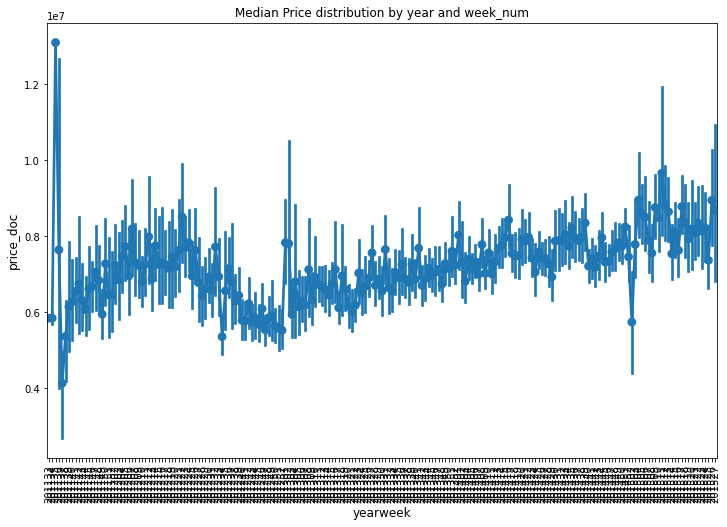

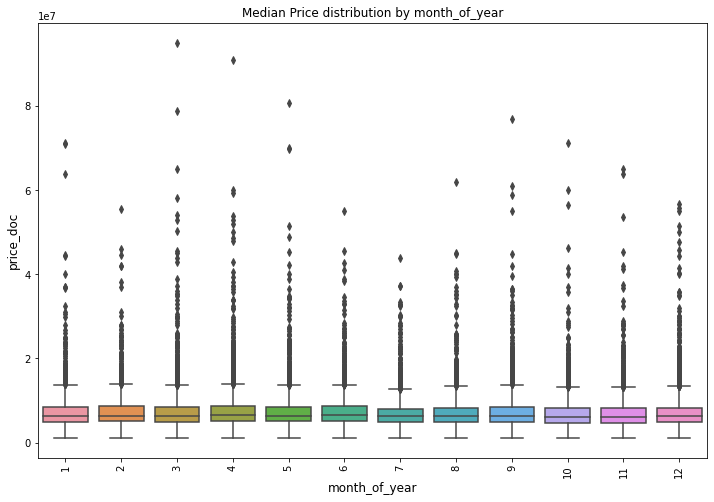

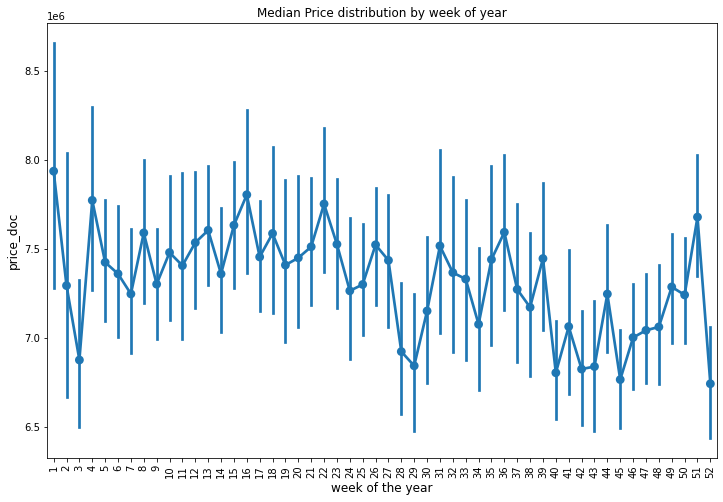

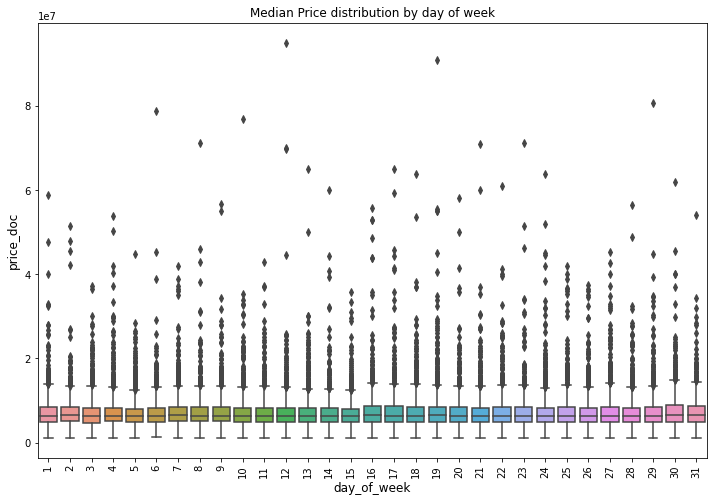

In [342]:
# Data plotting with using time aspects so we can understand data better 

plt.figure(figsize=(12,8))
sns.pointplot(x='yearweek', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('yearweek', fontsize=12)
plt.title('Median Price distribution by year and week_num')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(x=train_df["timestamp"].dt.month, y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('month_of_year', fontsize=12)
plt.title('Median Price distribution by month_of_year')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.pointplot(x=train_df["timestamp"].dt.isocalendar().week, y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('week of the year', fontsize=12)
plt.title('Median Price distribution by week of year')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(x=train_df["timestamp"].dt.day, y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('day_of_week', fontsize=12)
plt.title('Median Price distribution by day of week')
plt.xticks(rotation='vertical')
plt.show()

In [343]:
train_df.drop(["timestamp"], axis=1, inplace=True)
test_df.drop(["timestamp"], axis=1, inplace=True)

# Education ratios, education may have influence on buying specific house that nearby 

train_df["ratio_preschool"] = train_df["children_preschool"] / train_df["preschool_quota"].astype("float")
test_df["ratio_preschool"] = test_df["children_preschool"] / test_df["preschool_quota"].astype("float")

train_df["ratio_school"] = train_df["children_school"] / train_df["school_quota"].astype("float")
test_df["ratio_school"] = test_df["children_school"] / test_df["school_quota"].astype("float")

# Calculate age of building on sale, as build_year is one of the important features building age may have infulence on price
train_df["age_of_building"] = train_df["year"] -train_df["build_year"] 
test_df["age_of_building"] =    test_df["year"]- test_df["build_year"] 

# Floor of the house to the total number of floors in the house, important feautres so we want to have ratio between them
train_df["ratio_floor_max_floor"] = train_df["floor"] / train_df["max_floor"].astype("float")
test_df["ratio_floor_max_floor"] = test_df["floor"] / test_df["max_floor"].astype("float")

In [344]:
# Andy's magic numbers from Kaggle
train_df.loc[(train_df.product_type=='Investment') & (train_df.build_year<2000),'price_doc']*=0.9 
train_df.loc[train_df.product_type!='Investment','price_doc']*=0.969 

# Encode object type data using get.dummies (OneHotEncoding) and adding “null count” feature
lst = [train_df,test_df]
for da in lst:
    
    da['na_count']=da.isnull().sum(axis=1)
    df_cat=None
    to_remove=[]
    for c in da.columns:
        if da[c].dtype=='object':
            oh=pd.get_dummies(da[c],prefix=c)
            if df_cat is None:
                df_cat=oh
            else:
                df_cat=pd.concat([df_cat,oh],axis=1)
            to_remove.append(c)
    da.drop(to_remove,inplace=True,axis=1)

# Remove rare features and prevent overfitting –  the features which have sum of occurrences less than 200 will be removed.
    to_remove=[]
    if df_cat is not None:
        sums=df_cat.sum(axis=0)
        to_remove=sums[sums<200].index.values
        df_cat=df_cat.loc[:,df_cat.columns.difference(to_remove)]
        da = pd.concat([da, df_cat], axis=1)

# As seen above price log can get us better results so we use it

train_drp = pd.DataFrame(train_df.drop(["id", "price_doc"], axis=1))
train_y_drp = pd.DataFrame(np.log1p(train_df.price_doc.values))
test_X = test_df.drop(["id"] , axis=1)

from sklearn.model_selection import GridSearchCV


# I want to train the model and predict for submission, but one
# step before that I want to make sure that I am using optimal parameters 
# for the XGBoost model, so I can get better results 
# Only 2 values for each paramters due to high runtime

param_grid = {
    "objective": ["reg:squarederror"],
    "eval_metric": ["rmse"],
    "eta": [0.05, 0.1],
    "max_depth": [3,5],
    "subsample": [0.8, 0.9],
    "colsample_bytree": [0.8, 0.9],
    "seed": [0]
}

# Create the XGBoost model
model = xgb.XGBRegressor()

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=10)

# Fit the grid search to the data
# grid_search.fit(df_sample, train_y_sample)
grid_search.fit(train_drp, train_y_drp)

# Print the best parameters and score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best score: {:.4f}".format(grid_search.best_score_))

# Retrain the model using the best parameters
best_model = xgb.XGBRegressor(**grid_search.best_params_)
best_model.fit(train_drp, train_y_drp)

# Make predictions on the test set
y_test = best_model.predict(test_X)

# Save the predictions to a CSV file
y_test_unlog = np.expm1(y_test)
pd.DataFrame({"id": test_df["id"], "price_doc": y_test_unlog}).to_csv("submission_imporved_model.csv", index=False)



Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'colsample_bytree': 0.8, 'eta': 0.05, 'eval_metric': 'rmse', 'max_depth': 5, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.9}
Best score: 0.5446


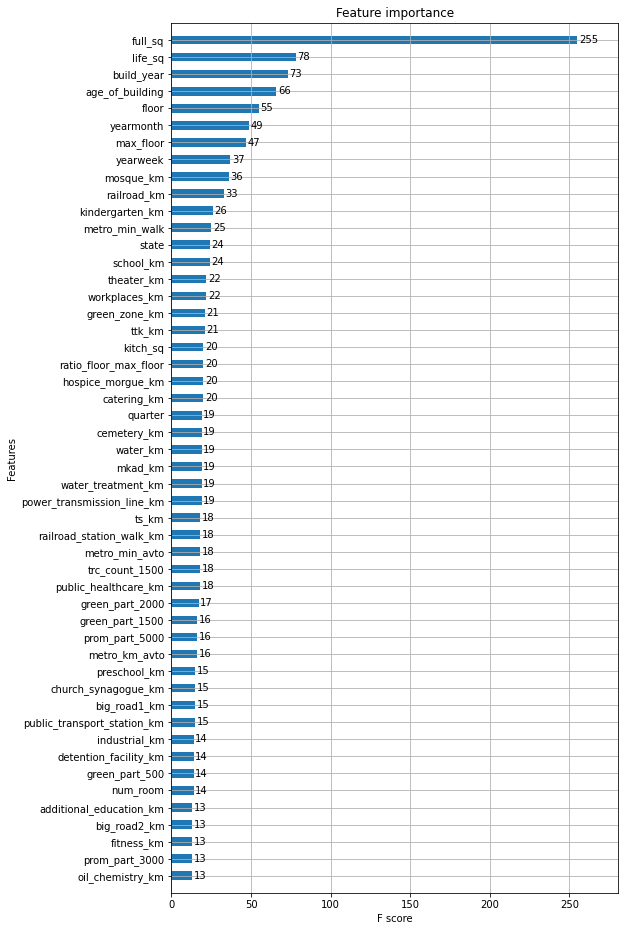

In [345]:
# Some of the features that I created are in top 50 important features, and some are even top 10!
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(best_model, max_num_features=50, height=0.5, ax=ax);

# Evaluating model using KFold

In [347]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

# Using KFold cross-validation to train and evaluate the model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
Best = grid_search.best_params_

train_drp = train_df.drop(["id", "price_doc"], axis=1)
train_y_drp = np.log1p(train_df.price_doc.values)
for train_index, val_index in kf.split(train_drp):
    X_train_kf, X_val_kf = train_drp.iloc[train_index], train_drp.iloc[val_index]
    y_train_kf, y_val_kf = train_y_drp[train_index], train_y_drp[val_index]
    dtrain = xgb.DMatrix(X_train_kf, label=y_train_kf)
    dval = xgb.DMatrix(X_val_kf, label=y_val_kf)
    model = xgb.train(Best, dtrain, num_boost_round=120, evals=[(dval, "val")], early_stopping_rounds=100, verbose_eval=20)
    y_val_pred = model.predict(dval)
    cv_scores.append(mean_squared_error(y_val_kf, y_val_pred) ** 0.5)



#Evaluate the mean and standard deviation of the cv scores
print(f'Mean cv RMSE: {np.mean(cv_scores)} +/- {np.std(cv_scores)}')


[0]	val-rmse:14.3809
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.17138
[40]	val-rmse:1.88661
[60]	val-rmse:0.749555
[80]	val-rmse:0.412804
[100]	val-rmse:0.341061
[119]	val-rmse:0.328321
[0]	val-rmse:14.3808
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.17006
[40]	val-rmse:1.8851
[60]	val-rmse:0.752051
[80]	val-rmse:0.421044
[100]	val-rmse:0.35413
[119]	val-rmse:0.342928
[0]	val-rmse:14.3604
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.15753
[40]	val-rmse:1.87599
[60]	val-rmse:0.741919
[80]	val-rmse:0.409026
[100]	val-rmse:0.341669
[119]	val-rmse:0.3304
[0]	val-rmse:14.3783
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.17039
[40]	val-rmse:1.88679
[60]	val-rmse:0.75131
[80]	val-rmse:0.414687
[100]	val-rmse:0.344365
[119]	val-rmse:0.331487
[0]	val-rmse:14.3722
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:5.16432
[40]	val-rmse:1.87966
[60]	val-rmse:0.745

**RMSE: 0.33452829135218315 +/- 0.005659781426304541**

**Kaggle Score: *Public:* 0.31753 , *Private:* 0.32126**

# Detecting Errors

Search for 3 top model predict errors:

In [348]:
# Looking for the predicted price vs. actual price using the data above
kf = pd.DataFrame({"indx": val_index, "price_doc": y_val_kf})
pred = pd.DataFrame({"indx": val_index, "price_doc": y_val_pred})
kf['price_doc'] = round(np.expm1(kf['price_doc']))
pred['price_doc']  = round(np.expm1(pred['price_doc']))

kf['price_doc_pred'] = pred['price_doc']
kf['diff_abs'] = abs(kf['price_doc']-pred['price_doc'])
print(kf)
diff = pd.DataFrame(kf['diff_abs'].nlargest(3))
diff_tbl = kf.iloc[[1398,632,2606]]

rs = train_df[train_df['id'].isin([7460,3560,13869])]

       indx   price_doc  price_doc_pred   diff_abs
0         9   2000000.0       5162802.0  3162802.0
1        11   4800000.0       4222972.0   577028.0
2        13   5200000.0       5026008.0   173992.0
3        16   6300000.0       5548294.0   751706.0
4        24   6000000.0       4707132.0  1292868.0
...     ...         ...             ...        ...
5886  29436   8941600.0       8852631.0    88969.0
5887  29437  12219090.0       7742631.0  4476459.0
5888  29446   8550000.0       6683387.0  1866613.0
5889  29453  22500000.0      14986655.0  7513345.0
5890  29455  13500000.0       9318764.0  4181236.0

[5891 rows x 4 columns]


In [349]:
# Finding the differences between actual price to predicted (absolute)
diff

,diff_abs
1398,62729192.0
632,53858988.0
2606,41963752.0


In [350]:
# Now differences comparing to acutal price and predicted price
diff_tbl

,indx,price_doc,price_doc_pred,diff_abs
1398,7057,91066096.0,28336904.0,62729192.0
632,3252,77000000.0,23141012.0,53858988.0
2606,13296,64000000.0,22036248.0,41963752.0


In [351]:
# Now we see all the data rows for those who had biggest mistake, so we can examine it and understand what went wrong
rs

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,year,yearmonth,yearweek,quarter,is_holiday,ratio_preschool,ratio_school,age_of_building,ratio_floor_max_floor,na_count
3557,3560,157,89.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2012,201209,201237,3,0,3.28785,1.073338,NaN,NaN,8
7457,7460,185,66.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2013,201304,201316,2,0,9.27021,0.987031,NaN,NaN,8
13866,13869,183,98.0,5.0,15.0,4.0,2010.0,4.0,17.0,1.0,...,2014,201401,201403,1,0,9.27021,0.987031,4.0,0.333333,0


In [352]:
print(train_df["full_sq"].mean())  # mean of full_sq
print(train_df.loc[train_df['full_sq'] > 150, 'full_sq'].count())  # counter of full_sq > 150
print(train_df.loc[train_df['full_sq'] > 150, 'full_sq'].count() / train_df.loc[train_df['full_sq'] > 0 ,'full_sq'].count()) # precentage out of all data

54.258682146858135
164
0.005567437281461113


So we can observe that the model was wrong where full_sq is high and may considered as an outlier so the model has difficulties to predict it correctly, full_sq mean is around 54 and less than 200 data points are full_sq>100 - less than 1% of the data! (calculated above) , and some of them has also nulls in important features so it also can make more difficulties and bias model predictions, therefore the model cannot predict them well since it has not a lot of information regarding those kind of houses.

# Time Aspects

Baseline model igonred time apsects and predict based on other features.
In the improved model I used a lot of time aspects which is important for the model and understanding times of year that sells are made at.
I used yearmonth and yearweek features, which help us understand specific period of times of the year that sell was made.
In addition, I used quarter feature so it help us to understand and devide sells by 4 quarters of the year, quarter may have an indirect effect on price so it can explain changes in demand in different seasons.
I also used "is_holiday" feature so we can notice diffrences at sells in when it's holiday or not (in that case specificlly I checked only 1 holiday - new year day which is global)


# Ways to improve the model

* It’s possible to try different model on the data – such as LGBM or other, they may have better performances – can have significant impact

* Creating some more features and validate – some impact

* Adding more external information – such as economy info or macro data

* Using different variables for Hyperparameter tuning, or expanding possible values to look for best option (High runtime) – some impact
